In [1]:
!gdown --id 1HiNTtDaZ4PTmE6ItFGhvR9ow5fyu06B4

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1HiNTtDaZ4PTmE6ItFGhvR9ow5fyu06B4
From (redirected): https://drive.google.com/uc?id=1HiNTtDaZ4PTmE6ItFGhvR9ow5fyu06B4&confirm=t&uuid=1d55101c-8bd0-4545-9c49-e7a0bfa805a9
To: /content/A. Segmentation.zip
100% 584M/584M [00:11<00:00, 52.1MB/s]


In [2]:
!unzip 'A. Segmentation.zip'

Archive:  A. Segmentation.zip
   creating: A. Segmentation/
   creating: A. Segmentation/1. Original Images/
   creating: A. Segmentation/1. Original Images/a. Training Set/
 extracting: A. Segmentation/1. Original Images/a. Training Set/IDRiD_01.jpg  
 extracting: A. Segmentation/1. Original Images/a. Training Set/IDRiD_02.jpg  
 extracting: A. Segmentation/1. Original Images/a. Training Set/IDRiD_03.jpg  
 extracting: A. Segmentation/1. Original Images/a. Training Set/IDRiD_04.jpg  
 extracting: A. Segmentation/1. Original Images/a. Training Set/IDRiD_05.jpg  
 extracting: A. Segmentation/1. Original Images/a. Training Set/IDRiD_06.jpg  
 extracting: A. Segmentation/1. Original Images/a. Training Set/IDRiD_07.jpg  
 extracting: A. Segmentation/1. Original Images/a. Training Set/IDRiD_08.jpg  
 extracting: A. Segmentation/1. Original Images/a. Training Set/IDRiD_09.jpg  
 extracting: A. Segmentation/1. Original Images/a. Training Set/IDRiD_10.jpg  
 extracting: A. Segmentation/1. Orig

In [3]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset
import matplotlib.pyplot as plt
from skimage import io

In [4]:
# Path
train_images_dir = "/content/A. Segmentation/1. Original Images/a. Training Set/"
train_mask_dir = "/content/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/5. Optic Disc/"
test_images_dir = "/content/A. Segmentation/1. Original Images/b. Testing Set/"
test_mask_dir = "/content/A. Segmentation/2. All Segmentation Groundtruths/b. Testing Set/5. Optic Disc/"

# Hyperparameters
batch_size = 8
learning_rate = 0.001

In [5]:
class MedicalImageDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, image_size=(512, 512)):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_size = image_size
        self.transform = transform
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image
        image_path = os.path.join(self.image_dir, self.image_files[idx])
        image = cv2.imread(image_path)
        image = cv2.resize(image, self.image_size)
        image = image / 255.0
        image = np.transpose(image, (2, 0, 1)) # CxHxW

        # Load mask
        mask_path = os.path.join(self.mask_dir, self.image_files[idx].replace('.jpg', '_OD.tif'))
        mask = np.zeros(self.image_size)
        if os.path.exists(mask_path):
            m = io.imread(mask_path)
            m = m.astype(np.uint8)
            mask = cv2.resize(m, self.image_size)
        mask = np.expand_dims(mask, axis=0) # 1xHxW

        image = torch.tensor(image, dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.float32)

        return image, mask

In [6]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
            )

        self.encoder1 = conv_block(in_channels, 64)
        self.encoder2 = conv_block(64, 128)
        self.encoder3 = conv_block(128, 256)
        self.encoder4 = conv_block(256, 512)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = conv_block(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder4 = conv_block(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = conv_block(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = conv_block(128, 64)

        self.output_layer = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        e1 = self.encoder1(x)
        e2 = self.encoder2(self.pool(e1))
        e3 = self.encoder3(self.pool(e2))
        e4 = self.encoder4(self.pool(e3))

        b = self.bottleneck(self.pool(e4))

        d4 = self.upconv4(b)
        d4 = torch.cat((d4, e4), dim=1)
        d4 = self.decoder4(d4)
        d3 = self.upconv3(d4)
        d3 = torch.cat((d3, e3), dim=1)
        d3 = self.decoder3(d3)
        d2 = self.upconv2(d3)
        d2 = torch.cat((d2, e2), dim=1)
        d2 = self.decoder2(d2)
        d1 = self.upconv1(d2)
        d1 = torch.cat((d1, e1), dim=1)
        d1 = self.decoder1(d1)

        return torch.sigmoid(self.output_layer(d1))

In [7]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for images, masks in loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(loader)

def validate_epoch(model, loader, criterion, device):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()
    return val_loss / len(loader)

def predict_masks(model, loader, device):
    model.eval()
    predictions = []
    images_list = []
    with torch.no_grad():
        for images, _ in loader:
            images = images.to(device)
            outputs = model(images)
            # outputs shape: B x 1 x H x W
            preds = outputs.cpu().detach().numpy()
            predictions.append(preds)
            images_list.append(images.cpu().numpy())
    return np.concatenate(predictions, axis=0), np.concatenate(images_list, axis=0)

In [8]:
# Dataset
train_dataset = MedicalImageDataset(train_images_dir, train_mask_dir, transform=None, image_size=(512, 512))
test_dataset = MedicalImageDataset(test_images_dir, test_mask_dir, transform=None, image_size=(512, 512))

# Chia thành labeled và unlabeled datasets
labeled_ratio = 0.2
labeled_size = int(labeled_ratio * len(train_dataset))
unlabeled_size = len(train_dataset) - labeled_size
labeled_dataset, unlabeled_dataset = random_split(train_dataset, [labeled_size, unlabeled_size])

# DataLoader
labeled_loader = DataLoader(labeled_dataset, batch_size=batch_size, shuffle=True)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Labeled dataset size: {len(labeled_dataset)}")
print(f"Unlabeled dataset size: {len(unlabeled_dataset)}")
print(f"Validation dataset size: {len(test_loader)}")

Labeled dataset size: 10
Unlabeled dataset size: 44
Validation dataset size: 4


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
def train_model_with_curriculum_labeling(model,
                                         labeled_dataset,
                                         unlabeled_dataset,
                                         val_loader,
                                         criterion,
                                         device,
                                         num_epochs_first_train=10,
                                         num_epochs_re_train=10,
                                         threshold=0.5):
    # Bước 1: First train trên labeled_dataset
    print("Step 1: Train model on initial labeled dataset")
    model = UNet(in_channels=3, out_channels=1).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    labeled_loader = DataLoader(labeled_dataset, batch_size=batch_size, shuffle=True)
    for epoch in range(num_epochs_first_train):
        train_loss = train_epoch(model, labeled_loader, criterion, optimizer, device)
        val_loss = validate_epoch(model, val_loader, criterion, device)
        print(f"Initial Train Epoch [{epoch+1}/{num_epochs_first_train}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


    current_unlabeled_dataset = unlabeled_dataset

    while len(current_unlabeled_dataset) > 0:
        print(f"Labeled dataset size: {len(labeled_dataset)}, Unlabeled dataset size: {len(current_unlabeled_dataset)}")

        # Bước 2: Dự đoán pseudo-label cho unlabeled dataset
        unlabeled_loader = DataLoader(current_unlabeled_dataset, batch_size=batch_size, shuffle=False)
        preds, imgs = predict_masks(model, unlabeled_loader, device)

        # Bước 3: Chọn sample
        num_samples = preds.shape[0]

        scores = preds.mean(axis=(1, 2, 3))  # shape: (N,)

        selected_indices = np.where(scores > threshold)[0]

        if len(selected_indices) == 0:
            num_top_samples = max(1, len(scores) // 5)
            selected_indices = np.argsort(scores)[-num_top_samples:]

        print(f"Selected {len(selected_indices)} samples out of {num_samples} for pseudo-labeling.")

        # Tạo pseudo-label dataset từ các sample đã chọn
        selected_data = []
        for idx in selected_indices:
            image, _ = current_unlabeled_dataset[idx]
            pseudo_mask = preds[idx,0,:,:]  # HxW
            pseudo_mask = torch.tensor(pseudo_mask, dtype=torch.float32).unsqueeze(0) # 1xHxW
            selected_data.append((image, pseudo_mask))

        # Loại bỏ các sample đã chọn ra khỏi unlabeled dataset
        remaining_indices = np.setdiff1d(np.arange(num_samples), selected_indices)
        remaining_data = []
        for idx in remaining_indices:
            image, mask = current_unlabeled_dataset[idx]
            remaining_data.append((image, mask))

        # Cập nhật unlabeled dataset
        class SimpleDataset(Dataset):
            def __init__(self, data_list):
                self.data_list = data_list
            def __len__(self):
                return len(self.data_list)
            def __getitem__(self, idx):
                return self.data_list[idx]

        pseudo_labeled_dataset = SimpleDataset(selected_data)
        current_unlabeled_dataset = SimpleDataset(remaining_data)

        # Kết hợp pseudo-labeled dataset với labeled_dataset cũ để tạo labeled_dataset mới
        new_labeled_dataset = ConcatDataset([labeled_dataset, pseudo_labeled_dataset])
        labeled_dataset = new_labeled_dataset

        # Bước 4: Huấn luyện mô hình với tập labeled_dataset mới
        print("Retraining model with new labeled dataset...")
        # model = UNet(in_channels=3, out_channels=1).to(device)
        # optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        labeled_loader = DataLoader(labeled_dataset, batch_size=batch_size, shuffle=True)
        for epoch in range(num_epochs_re_train):
            train_loss = train_epoch(model, labeled_loader, criterion, optimizer, device)
            val_loss = validate_epoch(model, val_loader, criterion, device)
            print(f"Retrain Epoch [{epoch+1}/{num_epochs_re_train}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    return model

criterion = nn.BCELoss()
model = UNet(in_channels=3, out_channels=1).to(device)

final_model = train_model_with_curriculum_labeling(
    model=model,
    labeled_dataset=labeled_dataset,
    unlabeled_dataset=unlabeled_dataset,
    val_loader=test_loader,
    criterion=criterion,
    device=device,
    num_epochs_first_train=40,
    num_epochs_re_train=10,
    threshold=0.5
)

torch.save(final_model.state_dict(), "unet_model_curriculum_labeling.pth")

model.load_state_dict(torch.load("unet_model_curriculum_labeling.pth"))

Step 1: Train model on initial labeled dataset
Initial Train Epoch [1/40], Train Loss: 0.7291, Val Loss: 0.6615
Initial Train Epoch [2/40], Train Loss: 0.5468, Val Loss: 0.6545
Initial Train Epoch [3/40], Train Loss: 0.4164, Val Loss: 12.5579
Initial Train Epoch [4/40], Train Loss: 0.3684, Val Loss: 90.6037
Initial Train Epoch [5/40], Train Loss: 0.4570, Val Loss: 5.7937
Initial Train Epoch [6/40], Train Loss: 0.3398, Val Loss: 0.7679
Initial Train Epoch [7/40], Train Loss: 0.3222, Val Loss: 46.7071
Initial Train Epoch [8/40], Train Loss: 0.3094, Val Loss: 68.2737
Initial Train Epoch [9/40], Train Loss: 0.2987, Val Loss: 63.2094
Initial Train Epoch [10/40], Train Loss: 0.2871, Val Loss: 59.6451
Initial Train Epoch [11/40], Train Loss: 0.2767, Val Loss: 53.3367
Initial Train Epoch [13/40], Train Loss: 0.2568, Val Loss: 19.3475
Initial Train Epoch [14/40], Train Loss: 0.2484, Val Loss: 3.7309
Initial Train Epoch [15/40], Train Loss: 0.2406, Val Loss: 2.1431
Initial Train Epoch [16/40], T

<ipython-input-11-a1bf73299e45>:103: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("unet_model_curriculum_labeling.pth"))


<All keys matched successfully>

In [12]:
def compute_iou(pred_mask, true_mask, threshold=0.5):
    pred_binary = (pred_mask > threshold).astype(np.uint8)

    # Intersection và Union
    intersection = np.logical_and(pred_binary, true_mask).sum()
    union = np.logical_or(pred_binary, true_mask).sum()

    if union == 0:
        return 1.0

    iou = intersection / union
    return iou

def evaluate_model_on_test_set(model, test_loader, device, threshold=0.5):
    model.eval()
    iou_scores = []

    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)  # Bx1xHxW
            preds = outputs.squeeze(1).cpu().numpy()
            true_masks = masks.squeeze(1).cpu().numpy()  # Ground truth masks

            # Tính IoU cho từng ảnh
            for pred, true_mask in zip(preds, true_masks):
                iou = compute_iou(pred, true_mask, threshold=threshold)
                iou_scores.append(iou)

    # Tính IoU trung bình
    mean_iou = np.mean(iou_scores)
    return mean_iou

def visualize_predictions(model, dataset, device, num_images=3):
    model.eval()
    plt.figure(figsize=(15, 5 * num_images))
    for i in range(num_images):
        image, mask = dataset[i]
        image = image.to(device).unsqueeze(0)
        with torch.no_grad():
            pred_mask = model(image)
        pred_mask = pred_mask.squeeze().cpu().numpy()
        pred_mask = (pred_mask > 0.5).astype(np.uint8)
        mask = mask.squeeze().numpy()
        image = image.squeeze().permute(1, 2, 0).cpu().numpy()

        # Hiển thị
        plt.subplot(num_images, 3, i * 3 + 1)
        plt.imshow(image)
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(num_images, 3, i * 3 + 2)
        plt.imshow(mask, cmap="gray")
        plt.title("Ground Truth")
        plt.axis("off")

        plt.subplot(num_images, 3, i * 3 + 3)
        plt.imshow(pred_mask, cmap="gray")
        plt.title("Predicted Mask")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

In [13]:
mean_iou = evaluate_model_on_test_set(final_model, test_loader, device, threshold=0.5)
print(f"Mean IoU on Testing Set: {mean_iou:.4f}")

Mean IoU on Testing Set: 0.6705


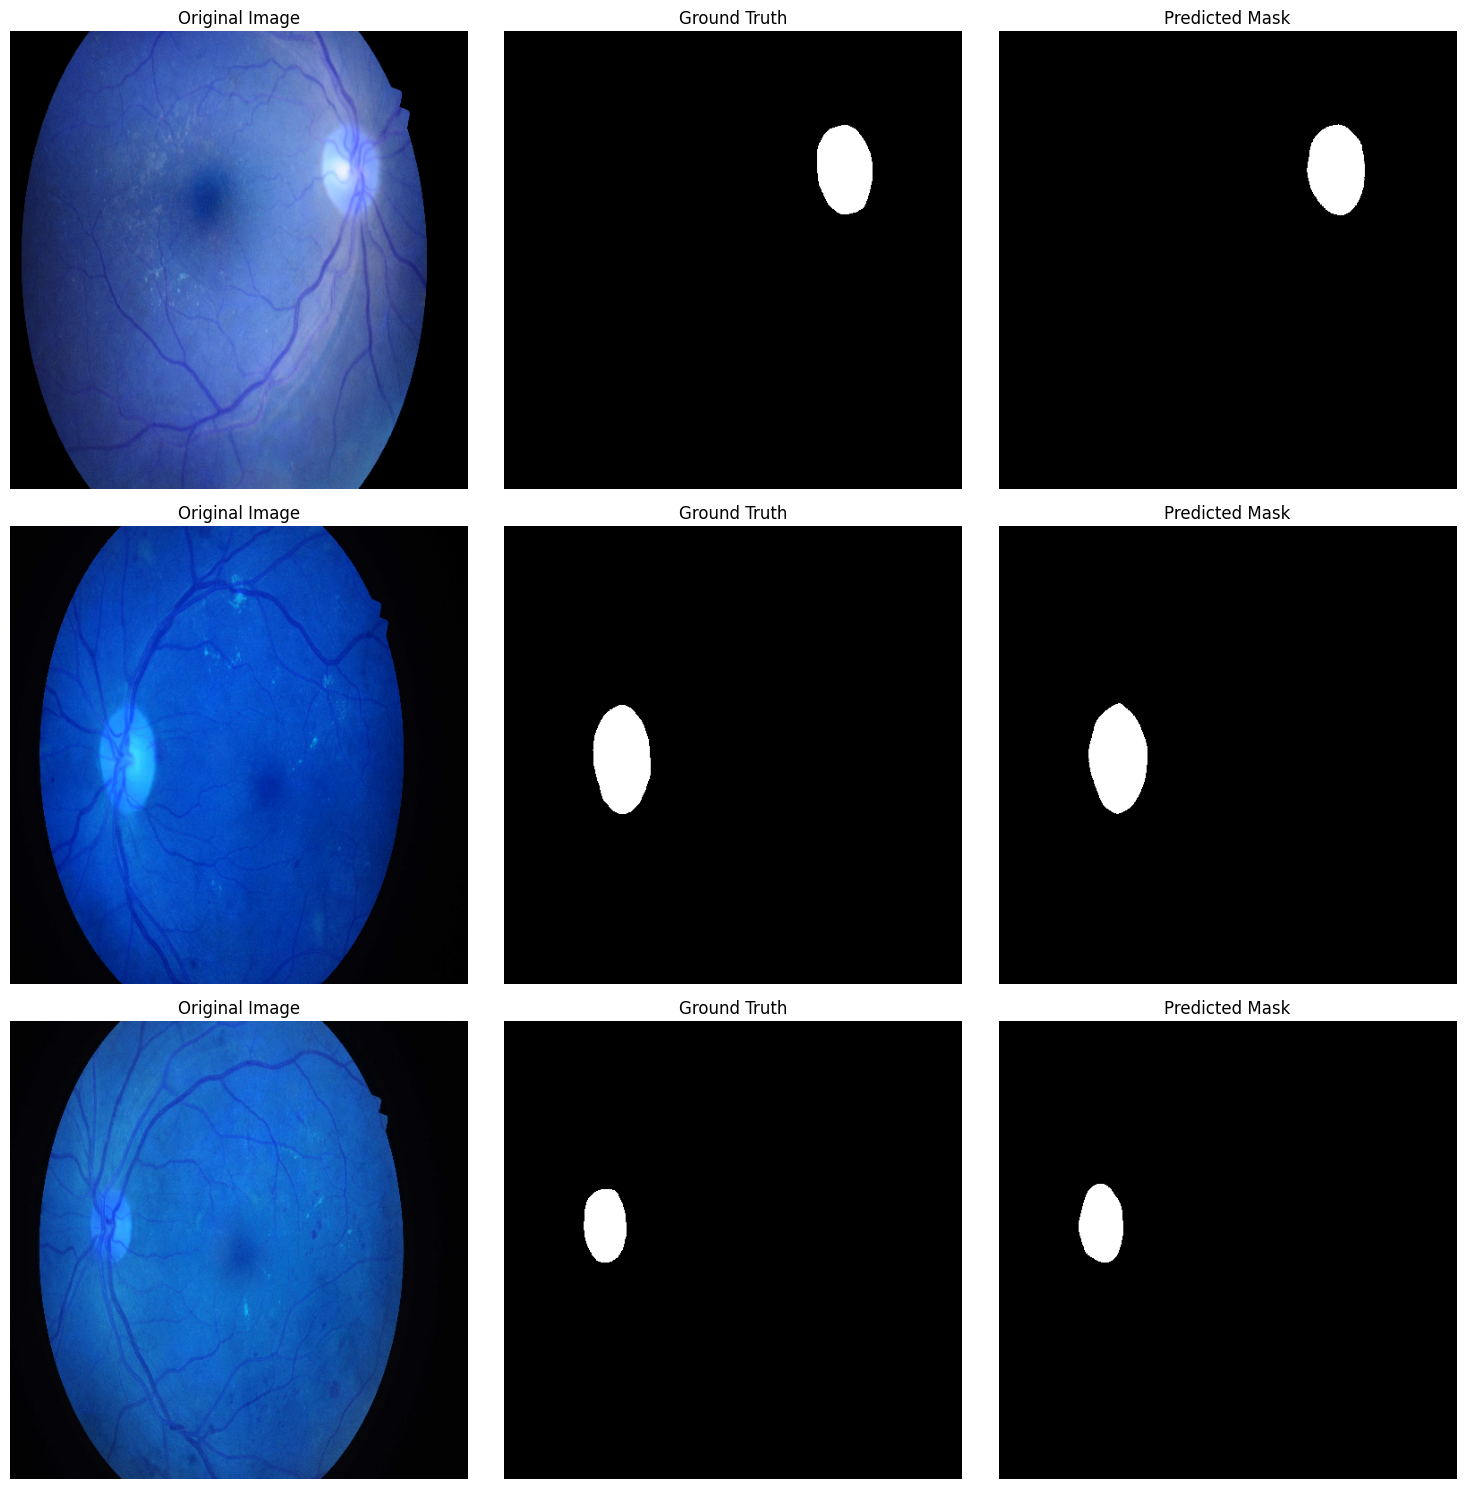

In [14]:
visualize_predictions(final_model, test_dataset, device, num_images=3)